<Strong> Note to the reader: </Strong> This notebook is to investigate more things about the XCorrelation of PanSTARRS and BOSS. Right now it looks at the pointing data of PanSTARRS, the data and the randoms generated to investigate that matching. 

Annotations about TreeCorr are taken from the documentation and all credit goes to Mike Jarvis. </br>

https://rmjarvis.github.io/TreeCorr/_build/html/overview.html </br>

-MT 6/16/20

#### List of changes/fixes that are not resolved: 

- 

### Imports and formatting: 

In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Image

In [29]:
#plt.switch_backend('agg') #For HEP, matplotlib x windows issues see python version for more usage 
import treecorr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import os
import datetime

import mpl_toolkits
mpl_toolkits.__path__.append('//miniconda3/envs/ccl/lib/python3.7/site-packages/mpl_toolkits/')
from mpl_toolkits.basemap import Basemap

### Define notebook wide data paths to use:

In [4]:
dataPath = '/Users/megantabbutt/CosmologyDataProducts/'
#dataPath = '/afs/hep.wisc.edu/home/tabbutt/private/CosmologyDataProducts/'

testingProductsPath = "/Users/megantabbutt/Cosmology/Cosmology/SNe CrossCorrelations/VerificationTestingProducts/"

In [5]:
# Define the paths for local and HEP machines:
DATA_PATH = '/Users/megantabbutt/CosmologyDataProducts/'
#DATA_PATH = '/afs/hep.wisc.edu/home/tabbutt/private/CosmologyDataProducts/'

TESTING_PRODUCTS_PATH = "/Users/megantabbutt/Cosmology/Cosmology/SNe CrossCorrelations/VerificationTestingProducts/"
#TESTING_PRODUCTS_PATH = "/afs/hep.wisc.edu/home/tabbutt/public/Cosmology/SNe CrossCorrelations/VerificationTestingProducts/"

# Create the directory to save to and a file with info about this run:
DATE = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M")
CURRENT_DIRECTORY = DATE
TESTING_PRODUCTS_PATH = TESTING_PRODUCTS_PATH + CURRENT_DIRECTORY

os.mkdir(TESTING_PRODUCTS_PATH)

NOTES_NAME = "/RUNNING_NOTES_" + DATE + ".txt"
NOTES_PATH = TESTING_PRODUCTS_PATH + NOTES_NAME

### Define notebook wide data paths to use:

In [6]:
''' Writes a string to a file.
File name: NOTES_NAME, path: NOTES_PATH. These are defined at the beginning of the program.

@param str notes: A single string to be writen.
'''

def NotesToWrite(notes):
    NOTES = open(NOTES_PATH, "a")
    NOTES.write(notes)
    NOTES.write("\n \n")
    NOTES.close()

### Start writing notes to textfile:
Write notes about:
- Steps completed in program
- plot made and saved to folder
- Amount of data points, randoms points in plots and data runs

In [7]:
# Write an opening note in the file:
NotesToWrite("BASE MAPS Version Run")

In [8]:
# Write an opening note in the file:
NotesToWrite("Created Running notes file for tracking details about this run and products produced/saved")

 <hr style="height:3px"> 


## 0. Pull in and parse data:

note: There are 10 pointings for the PanSTARRS data, we will use all 10 for the Auto Correlation, but when we correlated to CMASS, we need to only use the 9 overlap with CMASS. --- IMPORTANT

In [9]:
NotesToWrite("0. Pull in and parse data:")

#### PanSTARRS: 

In [10]:
connPAN = sqlite3.connect(dataPath + 'PanSTARRS.db')

qry = "SELECT ID, DEC, RA, zSN, zHost FROM PanSTARRSNEW WHERE (zSN > -999) || (zHost > -999)"

PanSTARRSNEW_GoodZ = pd.read_sql(qry, con=connPAN)
PanSTARRSNEW_GoodZ.head(3) # 1129 objects over 10 pointings 

,ID,DEC,RA,zSN,zHost
0,ps0909006,1.184831,333.9500,0.284,-999.0
1,ps0909010,-4.078911,37.1182,0.270,-999.0
2,ps0910017,-5.023289,35.2775,0.320,-999.0


In [11]:
NotesToWrite("PanSTARRSNEW_GoodZ Database (with 10 pointings) objects: " + str(len(PanSTARRSNEW_GoodZ)))

## 1. Create the TreeCorr Catalogs of Data:

In [12]:
NotesToWrite("1. Create the TreeCorr Catalogs of Data:")

In [13]:
cat_PanSTARRS_Full = treecorr.Catalog(ra=PanSTARRSNEW_GoodZ['RA'], dec=PanSTARRSNEW_GoodZ['DEC'], ra_units='degrees', 
                                      dec_units='degrees')
cat_PanSTARRS_Full

Catalog(x=array([ 0.89821907,  0.79537251,  0.81322895, ..., -0.44845015,
       -0.86674663, -0.46424765]),y=array([-0.43906143,  0.60193276,  0.57531887, ...,  0.53951108,
        0.49764081,  0.55135371]),z=array([ 0.02067772, -0.07113031, -0.08756066, ...,  0.71261508,
        0.033225  ,  0.69316896]),ra=array([5.82852704, 0.6478348 , 0.61570853, ..., 2.26428363, 2.62039894,
       2.2706359 ]),dec=array([ 0.02067919, -0.07119043, -0.08767293, ...,  0.79321874,
        0.03323112,  0.76587641]),w=array([1., 1., 1., ..., 1., 1., 1.]))

In [14]:
NotesToWrite("Created cat_PanSTARRS_Full.")

## 2. Create the randoms for PanSTARRS
Include all ten pointings for now, can just exclude the pointing that isn't in CMASS when doing the CrossCorr </br>

Possibility to ask for mask eventually if we think that it is a limitation </br>

In [16]:
NotesToWrite("2. Create the randoms for PanSTARRS. Include all 10 pointings, delete MD02 later.")

In [17]:
# Change this for more and less, 10E5 good for personal laptop ~5min run time
randsLength = 10**6

NotesToWrite("randsLength: " + str(randsLength))

In [18]:
ra_min_PanSTARRS = numpy.min(cat_PanSTARRS_Full.ra)
ra_max_PanSTARRS = numpy.max(cat_PanSTARRS_Full.ra)
dec_min_PanSTARRS = numpy.min(cat_PanSTARRS_Full.dec)
dec_max_PanSTARRS = numpy.max(cat_PanSTARRS_Full.dec)
print('PanSTARRS ra range = %f .. %f' % (ra_min_PanSTARRS, ra_max_PanSTARRS))
print('PanSTARRS dec range = %f .. %f' % (dec_min_PanSTARRS, dec_max_PanSTARRS))

rand_ra_PanSTARRS = numpy.random.uniform(ra_min_PanSTARRS, ra_max_PanSTARRS, randsLength)
rand_sindec_PanSTARRS = numpy.random.uniform(numpy.sin(dec_min_PanSTARRS), numpy.sin(dec_max_PanSTARRS), randsLength)
rand_dec_PanSTARRS = numpy.arcsin(rand_sindec_PanSTARRS)

PanSTARRS ra range = 0.600713 .. 6.172202
PanSTARRS dec range = -0.506386 .. 1.038391


In [19]:
# Got from a paper, need to cite it here:  https://arxiv.org/pdf/1612.05560.pdf

pointings = {"MD01": [035.875, -04.250], "MD03": [130.592, 44.317], "MD04": [150.000, 02.200], 
             "MD05": [161.917, 58.083], "MD06": [185.000, 47.117], "MD07": [213.704, 53.083], 
             "MD08": [242.787, 54.950], "MD09": [334.188, 00.283], "MD10": [352.312, -00.433], "MD02": [053.100, -27.800],}

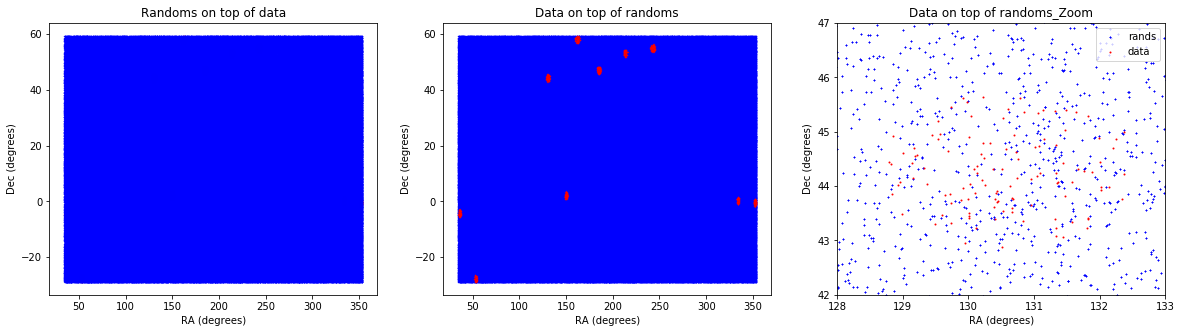

In [20]:
# Check how well the randoms cover the same space as the data

f1, (ax1a, ax2a, ax3a) = plt.subplots(1, 3, figsize=(20, 5))
ax1a.scatter(cat_PanSTARRS_Full.ra * 180/numpy.pi, cat_PanSTARRS_Full.dec * 180/numpy.pi, color='red', s=0.1, marker='x')
ax1a.scatter(rand_ra_PanSTARRS * 180/numpy.pi, rand_dec_PanSTARRS * 180/numpy.pi, color='blue', s=0.1)
ax1a.set_xlabel('RA (degrees)')
ax1a.set_ylabel('Dec (degrees)')
ax1a.set_title('Randoms on top of data')

# Repeat in the opposite order
ax2a.scatter(rand_ra_PanSTARRS * 180/numpy.pi, rand_dec_PanSTARRS * 180/numpy.pi, color='blue', s=0.1, marker='x')
ax2a.scatter(cat_PanSTARRS_Full.ra * 180/numpy.pi, cat_PanSTARRS_Full.dec * 180/numpy.pi, color='red', s=0.1)
ax2a.set_xlabel('RA (degrees)')
ax2a.set_ylabel('Dec (degrees)')
ax2a.set_title('Data on top of randoms')

# Zoom to look at coverage of randoms and reals
ax3a.scatter(rand_ra_PanSTARRS * 180/numpy.pi, rand_dec_PanSTARRS * 180/numpy.pi, color='blue', s=1, marker='x', label='rands')
ax3a.scatter(cat_PanSTARRS_Full.ra * 180/numpy.pi, cat_PanSTARRS_Full.dec * 180/numpy.pi, color='red', s=1, label='data')
ax3a.set_xlabel('RA (degrees)')
ax3a.set_ylabel('Dec (degrees)')
ax3a.set_title('Data on top of randoms_Zoom')
ax3a.legend(loc = "upper right")
ax3a.set_xlim(128, 133)
ax3a.set_ylim(42, 47)

plt.savefig(TESTING_PRODUCTS_PATH + "/PanSTARRS data and randoms")

plt.show()

In [21]:
NotesToWrite("Plotted: PanSTARRS data and randoms")

"The telescope illuminates a diameter of 3.3 degrees,  with low distortion, and mild vignetting at the edge of this illuminated region. The field of view is approximately 7 square degrees. The 8  meter  focal  length  atf/4.4  gives  an  approximate  10micron pixel scale of 0.258 arcsec/pixel."

7 square degrees --> r = 1.49 deg

In [22]:
# Make a mask that consists of the ten pointings populated with the randoms that are in it...
# Def a better way to do this? 

maskRA = []
maskDEC = []
randoms_Lengths = []

for pointing in pointings: 
    maskRAprevious = len(maskRA)
    X0 = pointings[pointing][0]
    Y0 = pointings[pointing][1]
    rad = 3.3/2
    print(pointings[pointing])
    
    for i in range(len(rand_ra_PanSTARRS)):
        #print(rand_ra_PanSTARRS[i], rand_dec_PanSTARRS[i])
        X = rand_ra_PanSTARRS[i] * 180 / numpy.pi
        Y = rand_dec_PanSTARRS[i] * 180 / numpy.pi
        
        if ((X - X0)**2 + (Y - Y0)**2 < rad**2):
            maskRA.append(X)
            maskDEC.append(Y)
    print(len(maskRA) - maskRAprevious)
    randoms_Lengths.append(len(maskRA) - maskRAprevious)

[35.875, -4.25]
337
[130.592, 44.317]
266
[150.0, 2.2]
355
[161.917, 58.083]
183
[185.0, 47.117]
250
[213.704, 53.083]
213
[242.787, 54.95]
208
[334.188, 0.283]
374
[352.312, -0.433]
320
[53.1, -27.8]
276


In [24]:
NotesToWrite("Populated pointings with randoms. Randoms per pointing: (1, 3-10, 2):"+ str(randoms_Lengths))

## 3. Check pointing overlaps

In [25]:
NotesToWrite("3. Check pointing overlap between pointing, data and randoms.")

//miniconda3/envs/ccl/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


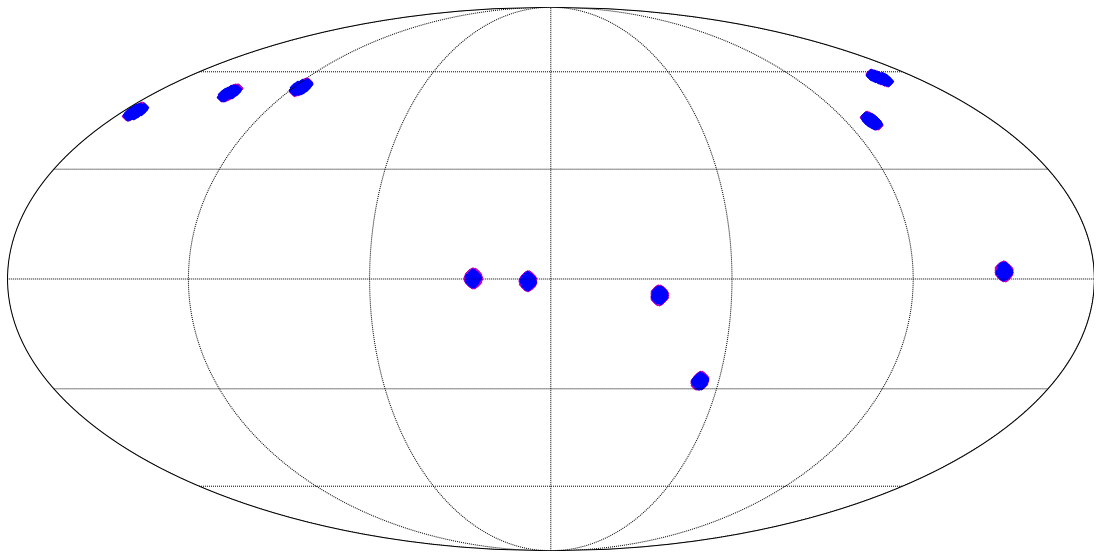

In [37]:
plt.figure(figsize=(20, 10))
map = Basemap(projection='moll', lon_0=0)

map.drawparallels(np.arange(-90.,120.,30.))
map.drawmeridians(np.arange(0.,420.,60.))

xRand, yRand = map(maskRA, maskDEC)
xData, yData = map(cat_PanSTARRS_Full.ra * 180/numpy.pi, cat_PanSTARRS_Full.dec * 180/numpy.pi)

map.scatter(xRand, yRand, marker='D', color='m')
map.scatter(xData, yData, marker='D', color='b')

plt.title("")
plt.show()

In [56]:
def makeMollWideZoom(pointing, zoomDegree):
    
    print("Center of pointing for " + pointing + ": " + str(pointings[pointing]))
    
    lat_0 = pointings[pointing][0]
    lon_0 = pointings[pointing][1]
    llcrnrlon = lon_0 - zoomDegree
    urcrnrlon = lon_0 + zoomDegree
    llcrnrlat = lat_0 - zoomDegree
    urcrnrlat = lat_0 + zoomDegree
    
    map = Basemap(projection='moll', lat_0=lat_0, lon_0=lon_0, llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat, 
                  urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat)

    xRand, yRand = map(maskRA, maskDEC)
    xData, yData = map(cat_PanSTARRS_Full.ra * 180/numpy.pi, cat_PanSTARRS_Full.dec * 180/numpy.pi)

    map.scatter(xRand, yRand, marker='D', color='m')
    map.scatter(xData, yData, marker='D', color='b')

    plt.title("")
    plt.show()

Center of pointing for MD01: [35.875, -4.25]


//miniconda3/envs/ccl/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]


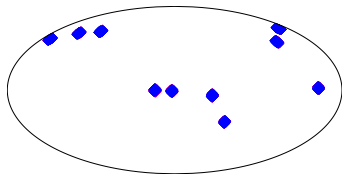

In [57]:
makeMollWideZoom("MD01", 2)